In [1]:
import sys, os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# %load_ext autoreload
# %autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim as O
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import gym
import inspect
import numpy as np
import h5py as hf
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
from foundation import sim as SIM
#from foundation.util import replicate, Cloner
from scipy import stats
np.set_printoptions(linewidth=120)

In [2]:
M = nn.Sequential(nn.Linear(10,4), nn.ReLU())
M

Sequential(
  (0): Linear(in_features=10, out_features=4, bias=True)
  (1): ReLU()
)

In [3]:
list(M)

[Linear(in_features=10, out_features=4, bias=True), ReLU()]

In [4]:
a = util.NS()
a.b.c.d = 'hello'
print(repr(a)) # --> NS('b':NS('c':NS('d':'hello')))

**WARNING: defaulting b
**WARNING: defaulting c
NS('b':NS('c':NS('d':'hello')))


In [3]:
a.todict()

{'b': {'c': {'d': 'hello'}}, '_ipython_canary_method_should_not_exist_': {}}

In [ ]:
nn.ConvTranspose2d

In [30]:
conv = nn.Conv2d(8, 8, 2, padding=1)
conv1 = nn.Conv2d(8, 8, 1)
conv2 = nn.Conv2d(8, 8, 2, stride=2)
conv

ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))

In [31]:
X = torch.randn(3, 8, 16, 16)

In [32]:
I = X
I = conv(I)
I = conv1(I)
I = conv2(I)
Y = I
Y.shape

torch.Size([3, 8, 30, 30])

In [102]:
X2 = F.interpolate(X, size=(32,32), mode='bilinear')
X2.shape

torch.Size([3, 8, 32, 32])

In [15]:
conv = nn.ConvTranspose2d(8, 8, 2, stride=2, padding=0, output_padding=0)
conv1 = nn.Conv2d(8, 8, 1)
conv2 = nn.Conv2d(8, 8, 2, stride=1, padding=0)
conv

ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))

In [16]:
X = torch.randn(3, 8, 16, 16)

In [17]:
I = X
I = conv(I)
# I = conv1(I)
# I = conv2(I)
Y = I
Y.shape

torch.Size([3, 8, 32, 32])

In [18]:
Y[0,0,-3:,-3:]

tensor([[-0.3772,  0.0454, -0.0426],
        [ 0.0254,  0.2793,  0.0524],
        [ 0.0236,  0.0150, -0.2716]], grad_fn=<SliceBackward>)

In [2]:
path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], '3dshapes', '3dshapes.h5')
path

'/is/ei/fleeb/workspace/local_data/3dshapes/3dshapes.h5'

In [4]:
dataset = hf.File(path, 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [12]:
images.shape, labels.shape

((480000, 64, 64, 3), (480000, 6))

In [19]:
torch.tensor([0,2,3]).tolist()

[0, 2, 3]

In [21]:
len(images)

480000

In [20]:
images[torch.tensor([0,2,3]).tolist()].shape

(3, 64, 64, 3)

In [15]:
np.array(torch.randn(3).cuda())

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [9]:
img = images[0]
img.shape

(64, 64, 3)

In [11]:
img.dtype

dtype('uint8')

<IPython.core.display.Javascript object>


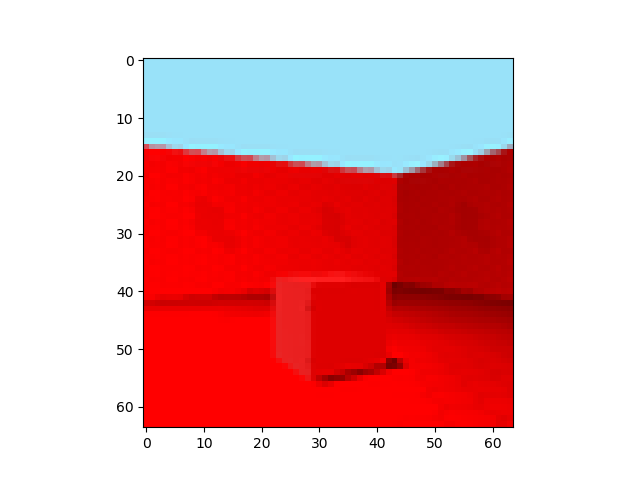

In [10]:
plt.imshow(img)

In [14]:
root = '/is/ei/fleeb/workspace/chome/trained_nets'
target = '/is/ei/fleeb/workspace/trained_nets/3dshapes_models'
util.create_dir(target)

In [15]:
from shutil import copyfile

In [16]:
names = ['checkpoint_100.pth.tar',]# 'best.pth.tar']

In [17]:
for d in [d for d in os.listdir(root) if '1205' in d]:
    print(d)
    for name in names:
        if name in os.listdir(os.path.join(root, d)):
            print('\t',name)
            if d not in os.listdir(target):
                os.mkdir(os.path.join(target,d))
            copyfile(os.path.join(root, d, name), os.path.join(target, d, name))
            copyfile(os.path.join(root, d, 'config.tml'), os.path.join(target, d, 'config.tml'))

fdwae1e-4-probp2_191205-145835
	 checkpoint_100.pth.tar
fdwae1e-4-plat-probp5_191205-145827
	 checkpoint_100.pth.tar
vae_191205-145825
	 checkpoint_100.pth.tar
fdwae1e-4-probp5_191205-145821
	 checkpoint_100.pth.tar
fdwae1e-4-probp5-priorp2_191205-145821
	 checkpoint_100.pth.tar
fdwae1e-3-probp5_191205-145824
	 checkpoint_100.pth.tar
wae-plat_191205-145819
	 checkpoint_100.pth.tar
fdvae1e-4-probp8_191205-145829
	 checkpoint_100.pth.tar
dwae1e-4-probp5_191205-145820
	 checkpoint_100.pth.tar
fwae_191205-145820
	 checkpoint_100.pth.tar
fdvae1e-4-probp5_191205-145826
	 checkpoint_100.pth.tar
fdwae1e-5-probp5_191205-145824
	 checkpoint_100.pth.tar
fdwae1e-4-probp8_191205-145827
	 checkpoint_100.pth.tar
wae_191205-145833
	 checkpoint_100.pth.tar
wpp1e-5_191205-145826
	 checkpoint_100.pth.tar
dwae1e-4-probp2_191205-145821
	 checkpoint_100.pth.tar
vae-plat_191205-145829
	 checkpoint_100.pth.tar
fdvae1e-4-probp2_191205-145831
	 checkpoint_100.pth.tar
fwae-plat_191205-145819
	 checkpoint_100.pth

In [19]:
os.listdir('/is/ei/fleeb/workspace/media/hybrid/new/3dshapes/pres')

['wae_191204-215052',
 'vae_191204-214838',
 'vaep01_191204-215053',
 'fvae_191204-214742',
 'fdwae1e-4-probp5_191204-214751',
 'fwae_191204-214848',
 'dwae1e-4-probp5_191205-145820',
 'fdwae1e-4-probp5-priorp2_191205-145821',
 'wpp1e-4_191204-214741',
 'gan-disclr3x_191204-214753',
 'wpp5e-5_191204-214751',
 'fdvae1e-4-probp5_191205-145826',
 'fdvae1e-4-probp2_191205-145831',
 'gan_191205-145831']

In [3]:
def f(x, *a, **kw):
    print(x, a, kw)

In [6]:
sig = inspect.signature(f)
sig.parameters

mappingproxy({'x': <Parameter "x">,
              'a': <Parameter "*a">,
              'kw': <Parameter "**kw">})

In [8]:
for n, p in sig.parameters.items():
    pass

In [11]:
p.kind

<_ParameterKind.VAR_KEYWORD: 4>

In [2]:
C = util.get_config('base')
C.keys()

AttributeError: module 'foundation.util' has no attribute 'get_config'

In [4]:
C.device

'cuda'

In [5]:
C.model

tdict('nonlin':'prelu', 'upsampling':'bilinear', 'downsampling':'max', 'norm_type':'instance')

In [2]:
data = np.load('../local_data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')
list(data.keys())

['metadata', 'imgs', 'latents_classes', 'latents_values']

In [3]:
def rec_decode(obj):
    if isinstance(obj, dict):
        return {rec_decode(k):rec_decode(v) for k,v in obj.items()}
    if isinstance(obj, list):
        return [rec_decode(x) for x in obj]
    if isinstance(obj, tuple):
        return tuple(rec_decode(x) for x in obj)
    if isinstance(obj, bytes):
        return obj.decode()
    return obj

In [4]:
data['latents_values'][:,1:].shape

(737280, 5)

In [5]:
meta = rec_decode(data['metadata'][()])
meta.keys()

dict_keys(['date', 'description', 'version', 'latents_names', 'latents_possible_values', 'latents_sizes', 'author', 'title'])

In [6]:
meta['date']

'April 2017'

In [7]:
meta['latents_sizes'][1:].sum()

113

In [16]:
lbls = data['latents_classes']
lbls.shape

(737280, 6)

In [19]:
lbls[10]

array([ 0,  0,  0,  0,  0, 10])

In [14]:
a = (1,2)
b = 3

In [17]:
*x, y = a
x, y

([1], 2)

In [5]:
a, *b, c = (1,2,3,4)

In [6]:
b

[2, 3]

In [9]:
images = data['imgs']
images.shape, images.dtype

((737280, 64, 64), dtype('uint8'))

In [10]:
images.max(), images.min()

(1, 0)

In [2]:
DS = train.get_dataset('dsprites', dataroot='../local_data/')
len(DS)

737280

In [4]:
DS.to('cuda')

RuntimeError: CUDA out of memory. Tried to allocate 11.25 GiB (GPU 0; 7.79 GiB total capacity; 0 bytes already allocated; 3.80 GiB free; 0 bytes cached)

In [2]:
new = True

In [3]:
if new:
    DS = train.get_dataset('mnist', dataroot='../local_data/', train=True, download=False)
    DS.to('cuda')
else:
    DS = torchvision.datasets.MNIST('../local_data/mnist', download=False, train=True, transform=torchvision.transforms.ToTensor())

DS = train.simple_split_dataset(DS, split=0.5, shuffle=False)[0]
    
len(DS)

30000

In [4]:
DS.indices.device

device(type='cuda', index=0)

In [5]:
loader, = train.get_loaders((DS,), batch_size=512, allow_batched=new)
len(loader)

Using batched data loader
traindata len=30000, trainloader len=59
Batch size: 512 samples


59

In [6]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

394 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

32.7 ms ± 762 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

4.23 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

1.99 ms ± 9.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [78]:
def moment(x,n=1):
    if n == 1:
        return x.mean()
    m = stats.moment(x,n)
    return np.sign(m)*np.abs(m)**(1/n)

In [114]:
N = 100000
x = np.random.randn(N)* 1 + 2
y = np.random.randn(N)* 2 + 3

In [115]:
xy = x*y
ms = [moment(xy,n) for n in range(1,5)]
print(', '.join(['{:2.3f}'.format(m) for m in ms]))

5.998, 5.344, 5.175, 7.769


<IPython.core.display.Javascript object>


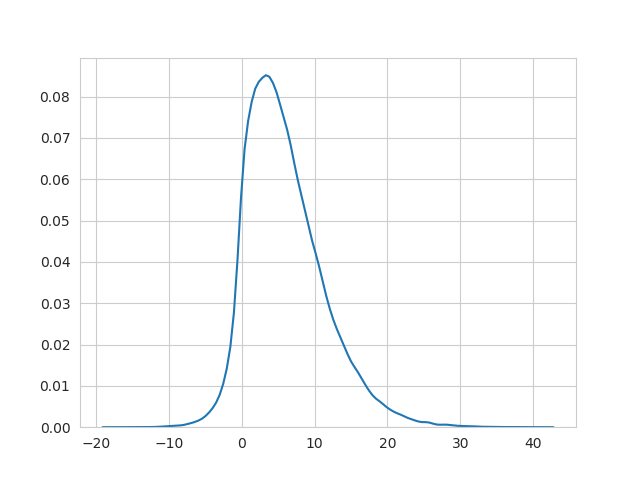

In [116]:
sns.kdeplot(xy)
# plt.xlim(-4,4)
# plt.ylim(-4,4)

In [2]:
N, D, M = 8, 4, 2

# class Test(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.A = nn.Linear(D,M)
#         self.B = self.A


X, Y = torch.randn(N,D), torch.randn(N, M)
X.shape, Y.shape

(torch.Size([8, 4]), torch.Size([8, 2]))

In [2]:
A = train.get_config()
A

**WARNING: defaulting _ipython_canary_method_should_not_exist_


<{'_ipython_canary_method_should_not_exist_':<{}>}>

In [4]:
A.model._type = 'stage'
A.model.stages = [
    train.Config(),
    train.Config(),
]
A.model.stages[0]._type = 'mlp'
A.model.stages[1]._type = 'mlp'
A.model.nonlin = 'elu'
A.model.hidden_dims = [64]

A.din = D
A.dout = M



<{'_ipython_canary_method_should_not_exist_':<{}>, 'model':<{'_type':'stage', 'stages':[<{}>, <{}>]}>}>

In [3]:
M1 = models.make_MLP(D,M, hidden_dims=[8])
M2 = models.make_MLP(D,M, hidden_dims=[])
print(M1)
print(M2)

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=8, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
)


In [4]:
M1.training

True

In [5]:
optim = util.Complex_Optimizer(M1=util.get_optimizer('adam',M1.parameters()), M2=util.get_optimizer('sgd',M2.parameters()))
optim

Complex_Optimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [6]:
scheduler = O.lr_scheduler.StepLR(optim, 1, gamma=.5)

In [8]:
print(optim)
scheduler.step()
print(optim)

Complex-Optimizer(
  M1: Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        initial_lr: 0.001
        lr: 0.0005
        weight_decay: 0
    )
  M2: SGD (
    Parameter Group 0
        dampening: 0
        initial_lr: 0.001
        lr: 0.0005
        momentum: 0
        nesterov: False
        weight_decay: 0
    )
)
Complex-Optimizer(
  M1: Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        eps: 1e-08
        initial_lr: 0.001
        lr: 0.00025
        weight_decay: 0
    )
  M2: SGD (
    Parameter Group 0
        dampening: 0
        initial_lr: 0.001
        lr: 0.00025
        momentum: 0
        nesterov: False
        weight_decay: 0
    )
)


In [5]:
for pg in optim.param_groups:
    print(pg.keys())

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad'])
dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])


In [16]:
list(optim.param_groups)

[{'params': [Parameter containing:
   tensor([[-0.1233, -0.3291, -0.0357,  0.2728],
           [ 0.4259, -0.0941,  0.1313,  0.4141],
           [ 0.2331, -0.4729, -0.0551, -0.4079],
           [ 0.3183, -0.4238, -0.4731,  0.3352],
           [ 0.2483,  0.1376, -0.0919,  0.4088],
           [ 0.2184,  0.4409,  0.4505,  0.2104],
           [ 0.0823, -0.1669,  0.3245, -0.2070],
           [ 0.2751,  0.0059, -0.3743, -0.0150]], requires_grad=True),
   Parameter containing:
   tensor([ 0.4951, -0.4274,  0.0804,  0.1836, -0.4684, -0.3420, -0.0827, -0.1058],
          requires_grad=True),
   Parameter containing:
   tensor([0.2500], requires_grad=True),
   Parameter containing:
   tensor([[-0.2400,  0.0860, -0.3046, -0.1266, -0.1415, -0.1294, -0.1883, -0.3226],
           [-0.0155,  0.2319,  0.0754,  0.3092,  0.2357, -0.3346,  0.0450, -0.2477]],
          requires_grad=True),
   Parameter containing:
   tensor([-0.1202,  0.2847], requires_grad=True)],
  'lr': 0.001,
  'betas': (0.9, 0.999),
 

In [13]:
optim

Complex_Optimizer ()

In [15]:
D = 10
Z = torch.zeros(1,D)
X = torch.linspace(-10,10,100).unsqueeze(-1).expand(-1,D)
Z.shape, X.shape

(torch.Size([1, 10]), torch.Size([100, 10]))

In [16]:
L = util.lorentzian(X,Z)
L.shape

torch.Size([100, 1])

<IPython.core.display.Javascript object>


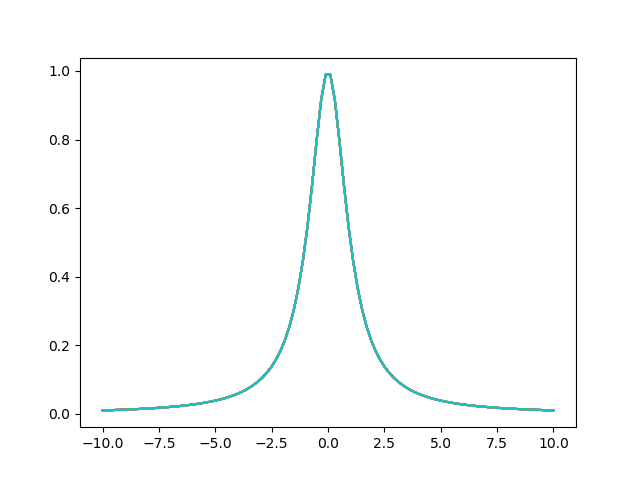

In [17]:
plt.figure()
plt.plot(X.squeeze().numpy(), L.squeeze().numpy())

In [15]:
proc = util.OUNoise(batch_size=4, mu=0., sigma=0.2, theta=.1)

In [16]:
proc(10).shape

torch.Size([4, 10, 1])

In [22]:
proc().shape

torch.Size([4, 1])

<IPython.core.display.Javascript object>


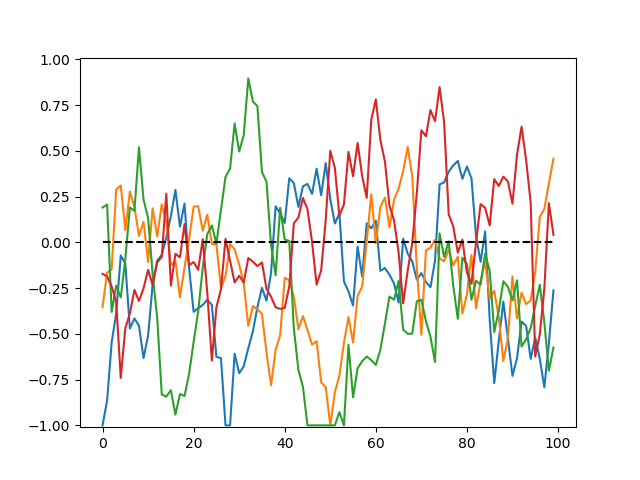

In [21]:

N = 100
t = torch.arange(N)
out = proc(N).squeeze()
plt.figure()
plt.plot(t.numpy(), out.squeeze().clamp(-1,1).numpy().T)
plt.plot(t.numpy(), torch.zeros_like(t).numpy(), c='k', ls='--')
plt.ylim(-1.01,1.01)
pass

In [9]:
import wikipedia

In [10]:
q1 = wikipedia.page('Machine Learning')
q1

<WikipediaPage 'Machine learning'>

In [16]:
pgs = wikipedia.random(10)
pgs

['Internet tutorial',
 'National Register of Historic Places listings in Lamar County, Texas',
 'Arabesque Partners',
 'Catholic Earthcare Australia',
 'Spororminula',
 'Mawhun',
 'List of Marie Claire cover models',
 'Walias Band',
 'Shahbaz Ali',
 'Fernand Steens']

In [18]:
wikipedia.

In [12]:
q1.links

['ACM Computing Classification System',
 'ACM Computing Surveys',
 'ADALINE',
 'AT&T Labs',
 'Action selection',
 'Active learning (machine learning)',
 'Adaptive website',
 'Affective computing',
 'Alan Turing',
 'Algorithm',
 'Algorithm design',
 'Algorithmic bias',
 'Algorithmic efficiency',
 'Amazon Machine Learning',
 'Analysis of algorithms',
 'Angoss',
 'Anomaly detection',
 'Apache Mahout',
 'Apache Spark',
 'Apache SystemML',
 'Application security',
 'ArXiv',
 'Array data structure',
 'Arthur Samuel',
 'Artificial Intelligence: A Modern Approach',
 'Artificial immune system',
 'Artificial intelligence',
 'Artificial neural network',
 'Artificial neural networks',
 'Artificial neuron',
 'Association rule learning',
 'Autoencoder',
 'Automata theory',
 'Automated machine learning',
 'Automated medical diagnosis',
 'Automated planning and scheduling',
 'Automated theorem proving',
 'Autonomous vehicle',
 'Ayasdi',
 'Azure Machine Learning',
 'Azure machine learning studio',
 'BI

In [4]:
pts = torch.randn(10,4)
pts.shape

torch.Size([10, 4])

In [10]:
sphr = util.cart2sphr(pts)
sphr.shape

torch.Size([10, 2])

In [11]:
cart = util.sphr2cart(sphr)
cart.shape

torch.Size([10, 2])

In [12]:
nn.MSELoss()(cart, pts)

tensor(8.5598e-15)

In [6]:
phis = util.cart2angl(pts)
phis

tensor([[1.1415, 0.8607, 4.7850],
        [1.0559, 2.2279, 1.6730],
        [1.3231, 1.4238, 3.9197],
        [2.3975, 1.8156, 2.4104],
        [0.9338, 3.0293, 1.8454],
        [1.6500, 2.2558, 4.0090],
        [1.0879, 0.4823, 4.8611],
        [1.9762, 0.9867, 4.4470],
        [1.3451, 1.1972, 1.7413],
        [2.5999, 2.9752, 0.5590]])

In [7]:
phis = util.cart2angl(pts*10)
phis

tensor([[1.1415, 0.8607, 4.7850],
        [1.0559, 2.2279, 1.6730],
        [1.3231, 1.4238, 3.9197],
        [2.3975, 1.8156, 2.4104],
        [0.9338, 3.0293, 1.8454],
        [1.6500, 2.2558, 4.0090],
        [1.0879, 0.4823, 4.8611],
        [1.9762, 0.9867, 4.4470],
        [1.3451, 1.1972, 1.7413],
        [2.5999, 2.9752, 0.5590]])

In [13]:
pts

tensor([[-0.9066, -0.1331],
        [ 0.3564, -1.0869],
        [ 2.1459,  0.5159],
        [ 0.1939, -0.1277],
        [-0.8157, -0.2721],
        [ 0.3785, -1.6743],
        [ 0.9632, -0.7964],
        [ 0.5483,  0.3598],
        [-0.6143, -1.4157],
        [-0.8995, -1.1065]])

In [14]:
sphr

tensor([[ 0.9163, -2.9958],
        [ 1.1438, -1.2539],
        [ 2.2070,  0.2360],
        [ 0.2322, -0.5823],
        [ 0.8599, -2.8196],
        [ 1.7165, -1.3484],
        [ 1.2498, -0.6909],
        [ 0.6558,  0.5808],
        [ 1.5432, -1.9802],
        [ 1.4260, -2.2534]])

In [26]:
net = models.make_MLP(10,3,hidden_dims=[20,30,10], nonlin='softplus')
net

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=30, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=30, out_features=10, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=10, out_features=3, bias=True)
)

In [29]:
for layer in net[:-1]:
    if isinstance(layer, nn.Linear):
        print(layer)

Linear(in_features=10, out_features=20, bias=True)
Linear(in_features=20, out_features=30, bias=True)
Linear(in_features=30, out_features=10, bias=True)


In [3]:
sim.sample_action()

tensor([0.8320])

In [4]:
sim.sample_state()

tensor([0.6750, 0.1724, 0.2784, 0.7560])

In [5]:
u = sim.sample_action()
u = torch.ones(1)*0
u

tensor([0.])

In [19]:
B = 16
state0 = torch.tensor([0,np.pi,1,0])
state0 = sim.sample_state(B)

In [23]:
x = sim.reset(state0)

In [24]:
bb = int(np.sqrt(B))
if bb**2 == B:
    fig, axes = plt.subplots(bb,bb)
else:
    fig, ax = plt.subplots(1)

In [25]:
for i in range(100):
    u = sim.sample_action(B)
    x = sim.step(u, N=1)
    imgs = sim.render(200,100)
    if len(imgs.shape) == 4:
        for img, ax in zip(imgs, axes.flat):
            ax.cla()
            ax.imshow(img)
            ax.axis('off')
    else:
        ax.cla()
        ax.imshow(imgs)
        ax.axis('off')
    plt.pause(0.03)

In [21]:
plt.cla()
plt.imshow(sim.render(200,100,index=0 if B is not None else None))
plt.axis('off')
pass

In [22]:
xs = []
for i in range(100):
    u = sim.sample_action(10)
    x = sim.step(u, N=1)
    xs.append(x)
    plt.cla()
    plt.imshow(sim.render(200,100, index=0 if B is not None else None))
    plt.axis('off')
    plt.pause(0.03)
x

tensor([[ -0.4271,   3.2266,   1.4794,   5.3090],
        [ -0.3441,   2.8913,   0.9614,   0.1135],
        [  0.8356,   3.8679,  -1.0499,   0.5847],
        [  0.6757,   0.8301,  -1.4260,   2.9928],
        [  0.1056,   2.0255,  -1.7367,  -7.1185],
        [  0.9208,   3.9876,   2.4905,   3.4231],
        [ -0.7255,   2.4377,   1.5289,   1.6305],
        [  0.6668,   2.8852,   4.6571,   6.4283],
        [  1.0004,   2.2665,   0.1500,   5.9317],
        [  0.4574,   3.2469,  -2.4065, -10.3370]])

In [23]:
X = torch.cat(xs)
X.shape

torch.Size([1000, 4])

In [2]:
dataroot = '/is/ei/fleeb/workspace/data'
name = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.hdf5'
name = '3dshapes.h5'
name = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
# DS = hf.File(os.path.join(dataroot, name))
DS = np.load(os.path.join(dataroot, name))
len(DS)

4

In [5]:
list(DS.keys())

['metadata', 'imgs', 'latents_classes', 'latents_values']

In [6]:
DS['imgs'].shape

[autoreload of foundation.data.collectors failed: Traceback (most recent call last):
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 300, in update_instances
    for obj in (ob

(737280, 64, 64)

In [3]:
for k in list(DS.keys()):
    print(k)
    print(k, DS[k].shape)

metadata


ValueError: Object arrays cannot be loaded when allow_pickle=False

In [73]:
DS['latents']['values'][0]

array([1. , 1. , 0.5, 0. , 0. , 0. ])

In [ ]:
DS.close()

In [43]:
torch.eye(10)[torch.randperm(10)]

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [7]:
B, D, M = 8, 4, 2

# class Test(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.A = nn.Linear(D,M)
#         self.B = self.A


X, Y = torch.randn(B,D), torch.randn(B, M)
X.shape, Y.shape

(torch.Size([8, 4]), torch.Size([8, 2]))

In [30]:
model = models.make_MLP(D,M,hidden_dims=[64,64,64,64, 64, 64])
model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_features=64, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=64, out_features=64, bias=True)
  (11): PReLU(num_parameters=1)
  (12): Linear(in_features=64, out_features=2, bias=True)
)

In [31]:
layers = [layer for layer in model if isinstance(layer, nn.Linear)][:-1]
layers

[Linear(in_features=4, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True)]

In [38]:
dX = X+torch.randn_like(X)

In [39]:
fmatch = models.Feature_Match(layers, model=model)
with torch.no_grad():
    loss = fmatch(X,dX)
loss

tensor(0.0613)

In [40]:
fmatch = models.Feature_Match(model, model=model)
with torch.no_grad():
    loss = fmatch(X,dX)
loss

tensor(0.0432)

In [27]:
model.A.weight.data[0,0] += 1
model.A.weight, model.B.weight

(Parameter containing:
 tensor([[ 3.0000, -0.3344],
         [-0.1594, -0.0811]], requires_grad=True), Parameter containing:
 tensor([[ 3.0000, -0.3344],
         [-0.1594, -0.0811]], requires_grad=True))

In [26]:
model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [16]:
p = nn.utils.parameters_to_vector(model.parameters())

In [14]:
loss = nn.MSELoss()(model(X), Y)
loss

tensor(0.3756, grad_fn=<MseLossBackward>)

In [15]:
model.zero_grad()
loss.backward()

In [19]:
for param in model.parameters():
    print(param.grad)

tensor([[ 0.0097, -0.0273],
        [ 0.1568, -0.0930]])
tensor([0.1551, 0.0066])


In [14]:
outputs = []
def keep(m, x, y):
    outputs.append(y)

In [6]:
model = torchvision.models.squeezenet1_0(pretrained=True, progress=True).cuda()
# model.features.register_forward_hook(keep)
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [9]:
x = torch.rand(4,3,128,128).cuda()
x.shape

torch.Size([4, 3, 128, 128])

In [17]:
y = model(x)
y.shape

torch.Size([4, 1000])

In [19]:
outputs[0].shape

torch.Size([4, 512, 7, 7])

In [19]:
info = torch.load('rl/temp_xy.pth.tar')
info.keys()

dict_keys(['y', 'm_old', 'x', 'm_new', 'l_new', 'l_old'])

In [20]:
X, Y = info['x'], info['y']
X.shape, Y.shape

(torch.Size([2050, 4]), torch.Size([2050, 1]))

In [21]:
mn, mo = info['m_new'], info['m_old']
print(list(mn.parameters()))
print(list(mo.parameters()))

[Parameter containing:
tensor([[ -6.0671, -15.6417,   1.6947,  -0.5189]]), Parameter containing:
tensor([5.8610])]
[Parameter containing:
tensor([[-0.4195,  0.3034,  0.2341,  0.3355]]), Parameter containing:
tensor([0.1772])]


In [22]:
info['l_old'], info['l_new']

(tensor(28.8512), tensor(5.7119))

In [3]:
N,M,D = 20, 5, 3
with torch.no_grad():
    A = torch.randn(N,M)
    f = nn.Linear(M,D)
    b = f(A)
    m = nn.Linear(M,D)

In [5]:
F.mse_loss(m(A), b)

tensor(1.1172, grad_fn=<MseLossBackward>)

In [6]:
util.solve(A,b,out=m)

Linear(in_features=5, out_features=3, bias=True)

In [7]:
F.mse_loss(m(A), b)

tensor(3.1220e-14, grad_fn=<MseLossBackward>)

In [25]:
shapes, settings = nets.plan_deconv(out_shape=(3,160,120), channels=[8, 16, 32, 64], kernels=4, strides=2)
shapes

[(8, 10, 7), (16, 20, 15), (32, 40, 30), (64, 80, 60), (3, 160, 120)]

In [26]:
ms = nn.ModuleList([nn.ConvTranspose2d(**s) for s in settings])
ms

ModuleList(
  (0): ConvTranspose2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
  (1): ConvTranspose2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (2): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [29]:
X = torch.randn(1, *shapes[0])

In [30]:
x = X
print(x.size())
for m in ms:
    x = m(x)
    print(x.size())

torch.Size([12, 8, 10, 7])
torch.Size([12, 16, 20, 15])
torch.Size([12, 32, 40, 30])
torch.Size([12, 64, 80, 60])
torch.Size([12, 3, 160, 120])


In [22]:
print(x.shape)
print(m)

torch.Size([12, 8, 10, 8])
ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [45]:
shapes, settings = nets.plan_conv((3,160,120), channels=[8, 16, 32, 64], kernels=3, strides=1, factors=2)
shapes

[(3, 160, 120), (8, 80, 60), (16, 40, 30), (32, 20, 15), (64, 10, 8)]

In [46]:
ms = nn.ModuleList([nn.Conv2d(**s) for s in settings])
ms

ModuleList(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [47]:
X = torch.randn(1, *shapes[0])

In [48]:
x = X
print(x.size())
for m in ms:
    x = m(x)
    print(x.size())

torch.Size([1, 3, 160, 120])
torch.Size([1, 8, 160, 120])
torch.Size([1, 16, 160, 120])
torch.Size([1, 32, 160, 120])
torch.Size([1, 64, 160, 120])


In [ ]:
ms = nn.ModuleList([nn.Conv2d(**s) for s in settings])

In [3]:
class OU_Process:
    def __init__(self, K=3, std=0.5, theta=0.5):
        self.K = K
        self.std = std
        self.theta = theta
        
        self.x = torch.randn(K) * self.std
        
    def __call__(self, t, state):
        return self.theta * self.x + torch.randn(self.K) * self.std
    
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

In [4]:
#env.alpha = 5.
#env.beta = 5.
#env.gamma = 0.1

In [5]:
env.reset()#(-torch.ones(2)*np.pi/2, torch.zeros(2))
#policy = OU_Process(K=env.N, std=0.5, theta=0.7)
policy = lambda t, x: torch.rand(env.spec.action_space.size)*2 - 1
plt.ioff()

In [6]:
rgb, lbl = env.render(label=True)
rgb.shape, lbl.shape

((200, 200, 3), (200, 200))

In [7]:
env.obs

tensor([-0.9174,  0.9359, -0.3980,  0.3524, -0.0811,  2.2122, -0.5983,
         0.3812,  0.0092, -0.0228])

In [8]:
plt.ion()
plt.figure()
plt.imshow(rgb, interpolation='none')

plt.figure()
plt.imshow(lbl, interpolation='none')

In [9]:
plt.ion()
figax = plt.subplots(figsize=(3,3))
fig, ax = figax
ax.set_xticks([])
ax.set_yticks([])

[]

In [10]:
for t in range(1000):
    
    action = policy(t, None) #+ 1
    env.step(action)
    
    ax.set_title('{:.3f} {:.3f}'.format(action[0].item(), action[1].item()))
    
    env.render('onscreen', figax=figax)
    plt.pause(0.002)
    ax.cla()
    #break

In [10]:
plt.show()

In [8]:
rgb = fig2data(fig)
rgb.shape

/home/fleeb/anaconda3/envs/cse/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(409, 400, 4)

In [7]:
plt.figure()
#plt.axis('off')
plt.imshow(env.render('rgb'))
plt.show()

In [7]:
env.get_ctrl_freq()

60.0